In [47]:
#1. Global methane levels from 2002
# Load modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import netCDF4
from netCDF4 import Dataset


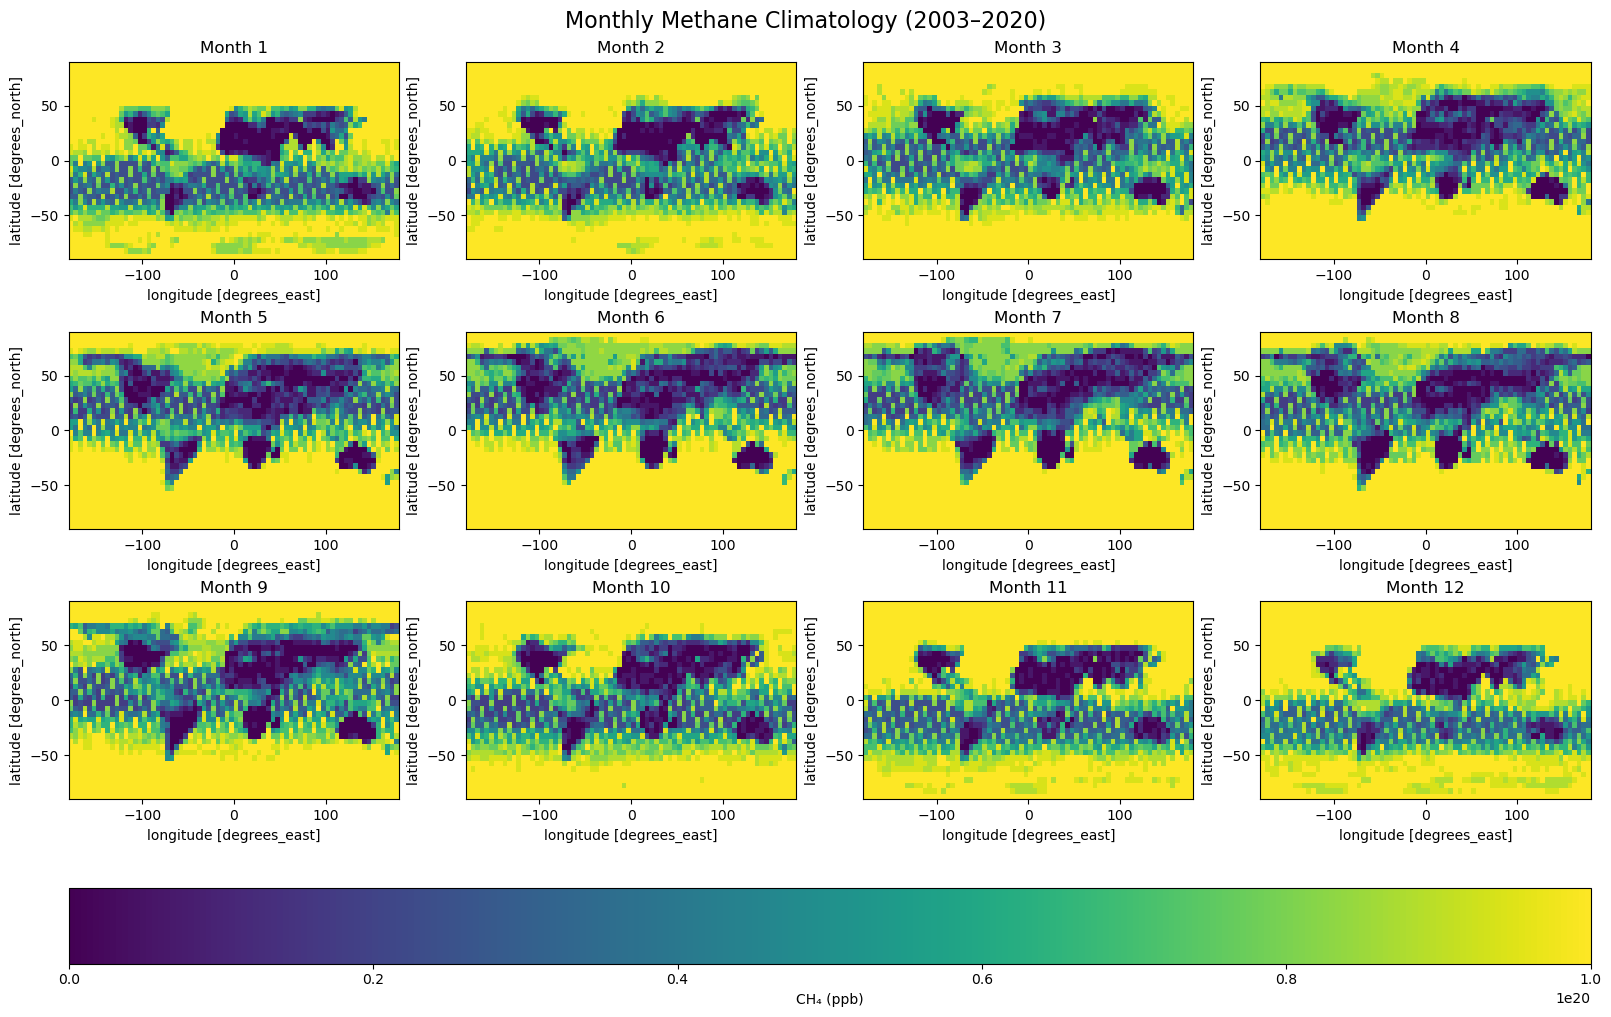

In [142]:
import xarray as xr
import matplotlib.pyplot as plt

# 读取数据
ds = xr.open_dataset(r"200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc")
xch4 = ds['xch4']  # shape: (time, lat, lon)

# 提取月份
monthly_climatology = xch4.groupby('time.month').mean(dim='time')

# 绘图
fig, axes = plt.subplots(3, 4, figsize=(16, 10), constrained_layout=True)
for i, ax in enumerate(axes.flat):
    pcm = monthly_climatology[i].plot(ax=ax, cmap='viridis', add_colorbar=False)
    ax.set_title(f"Month {i+1}")
fig.colorbar(pcm, ax=axes.ravel().tolist(), orientation='horizontal', pad=0.05, label='CH₄ (ppb)')
plt.suptitle("Monthly Methane Climatology (2003–2020)", fontsize=16)
plt.show()


原始单位: 1


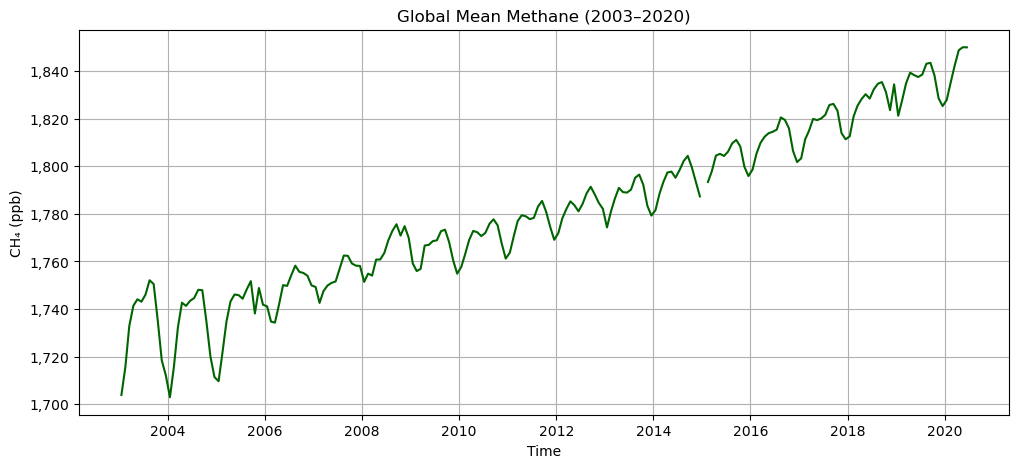

In [143]:
xch4 = ds['xch4'].where(ds['xch4'] < 1e20)
# 检查单位
units = ds['xch4'].attrs.get('units', '').lower()
print("原始单位:", units)
# 转换到 ppb
if units in ('mol mol-1', 'mol/mol', '1', 'fraction'):
    xch4 = xch4 * 1e9
    ylabel = "CH₄ (ppb)"
elif units == 'ppm':
    xch4 = xch4 * 1e3
    ylabel = "CH₄ (ppb)"
elif units == 'ppb':
    ylabel = "CH₄ (ppb)"
else:
    ylabel = f"CH₄ ({units})"  # 如果未知，就显示原始单位
# 计算全球平均
global_mean = xch4.mean(dim=['lat', 'lon'])
# 自定义刻度格式（千位分隔）
def format_ppb(x, pos):
    return f"{x:,.0f}"
# 绘图
fig, ax = plt.subplots(figsize=(12, 5))
global_mean.plot(ax=ax, color='darkgreen')

ax.set_title("Global Mean Methane (2003–2020)")
ax.set_ylabel(ylabel)
ax.set_xlabel("Time")
ax.grid(True)

ax.yaxis.set_major_formatter(FuncFormatter(format_ppb))

plt.show()


Detected mole fraction; converting to ppb by multiplying 1e9.


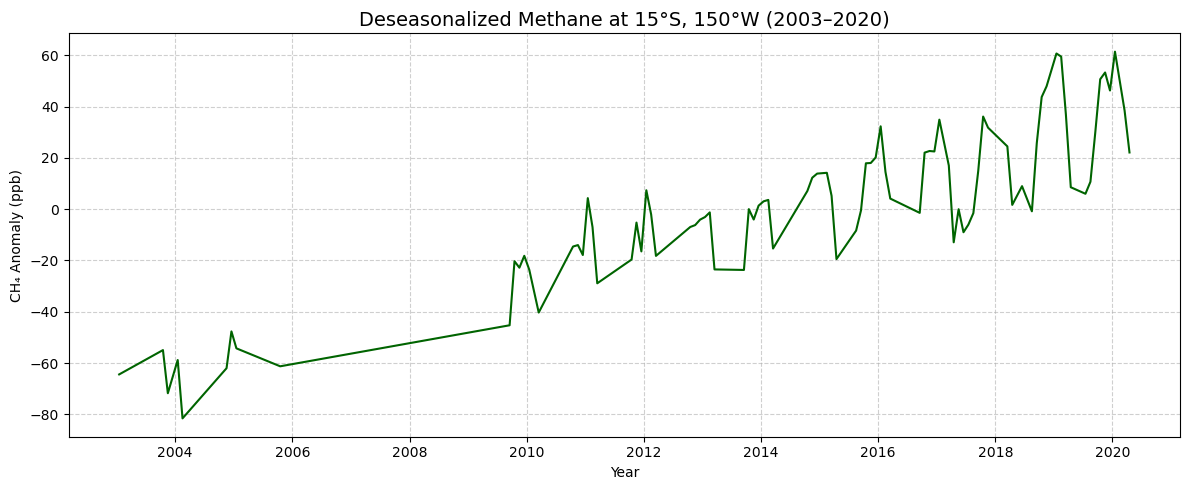

该点的甲烷浓度去除季节性后仍呈上升趋势，说明长期趋势明显。


In [144]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_path = r"200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"
ds = xr.open_dataset(file_path, decode_cf=True)

var_name = 'xch4'
target_lat = -15.0
target_lon = -150.0

# 处理经度范围 [0, 360] vs [-180, 180]
if ds.lon.min() >= 0:
    target_lon = 360 + target_lon

lat_idx = np.abs(ds.lat - target_lat).argmin()
lon_idx = np.abs(ds.lon - target_lon).argmin()

# 提取并屏蔽无效值
ts = ds[var_name].isel(lat=lat_idx, lon=lon_idx)
ts = ts.where(ts < 1e10)  # 移除填充值

sample_val = ts.dropna(dim='time').isel(time=0).item()
if sample_val < 1:  # 启发式判断：小于1很可能是摩尔分数
    print("Detected mole fraction; converting to ppb by multiplying 1e9.")
    ts = ts * 1e9
else:
    print("Values appear to be in ppb already.")

# 确保时间维度正确
if not np.issubdtype(ts.time.dtype, np.datetime64):
    ts['time'] = xr.date_range('2003-01', periods=ts.sizes['time'], freq='MS')

# === GroupBy 去季节化 ===
monthly_clim = ts.groupby('time.month').mean(dim='time')
clim_series = monthly_clim.sel(month=ts['time.month'])
deseasonalized = ts - clim_series

# 转为 pandas 并绘图
deseason_pd = deseasonalized.to_series().dropna()

plt.figure(figsize=(12, 5))
plt.plot(deseason_pd.index, deseason_pd.values, color='darkgreen')
plt.ticklabel_format(style='plain', axis='y')  # 禁用科学计数法
plt.title('Deseasonalized Methane at 15°S, 150°W (2003–2020)', fontsize=14)
plt.ylabel('CH₄ Anomaly (ppb)')
plt.xlabel('Year')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
print("该点的甲烷浓度去除季节性后仍呈上升趋势，说明长期趋势明显。")

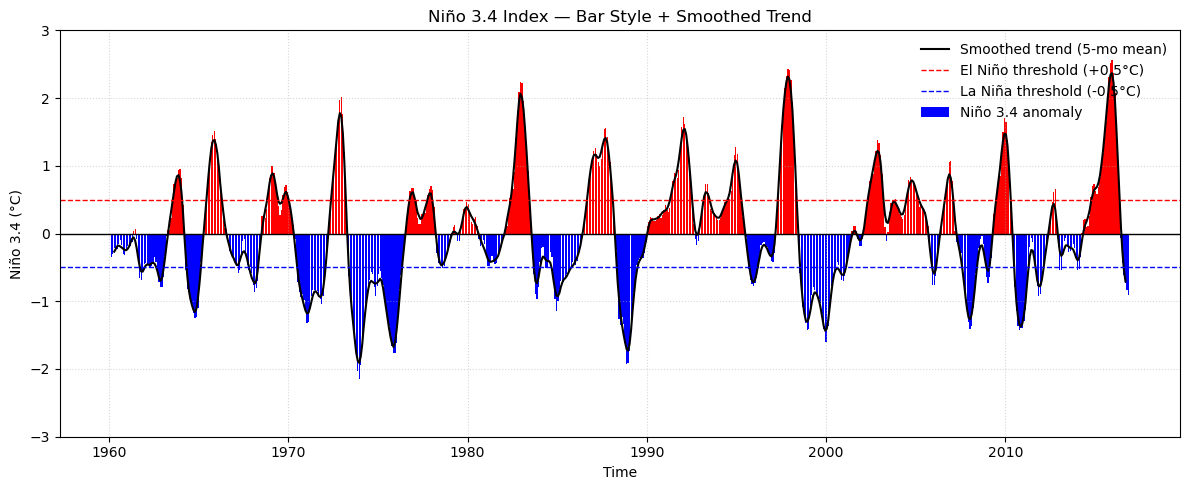

In [145]:
#2. Niño 3.4 index
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


# 读取数据

file_path = r"NOAA_NCDC_ERSST_v3b_SST.nc"
ds = xr.open_dataset(file_path)

# 数据变量名一般为 'sst'
sst = ds['sst']


# 选择 Niño 3.4 区域（5°S–5°N，170°W–120°W）
# 注意经度一般为 0~360，需转换

lat_cond = (ds.lat >= -5) & (ds.lat <= 5)

# 经度：170W=190E, 120W=240E
lon_cond = (ds.lon >= 190) & (ds.lon <= 240)

sst_n34 = sst.sel(lat=lat_cond, lon=lon_cond)

# 区域平均
sst_n34_mean = sst_n34.mean(dim=['lat','lon'])
# 1.1 计算 climatology（每个月的长期平均）

climatology = sst_n34_mean.groupby('time.month').mean('time')


# 计算 anomaly = 实际值 - 月度 climatology
sst_anom = sst_n34_mean.groupby('time.month') - climatology

# 计算 Niño 3.4 Index（一般是3个月滑动平均）
nino34 = sst_anom.rolling(time=3, center=True).mean()

# 1.2 画图：红蓝柱状图 + 平滑趋势线
import pandas as pd

# 提取时间和数值
time = pd.to_datetime(nino34.time.values)
values = nino34.values

plt.figure(figsize=(12, 5))
ax = plt.gca()

bar_width = 25  

# 条形图：正值红色，负值蓝色
colors = ['red' if v >= 0 else 'blue' for v in values]
ax.bar(time, values, width=bar_width, color=colors, align='center', label='Niño 3.4 anomaly')

# 趋势线：用更长窗口平滑，避免与柱状图完全重合
trend = pd.Series(values).rolling(window=5, center=True).mean()
ax.plot(time, trend, color='black', lw=1.5, label='Smoothed trend (5-mo mean)')

# 阈值线
ax.axhline(0, color='black', lw=1)
ax.axhline(0.5, color='r', linestyle='--', lw=1, label='El Niño threshold (+0.5°C)')
ax.axhline(-0.5, color='b', linestyle='--', lw=1, label='La Niña threshold (-0.5°C)')

# 图像样式
ax.set_ylim(-3, 3)
ax.set_title("Niño 3.4 Index — Bar Style + Smoothed Trend")
ax.set_xlabel("Time")
ax.set_ylabel("Niño 3.4 (°C)")
ax.legend(loc='upper right', frameon=False)
ax.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()



C:\Users\45527\AppData\Local\Temp\ipykernel_95316\3552528621.py:9: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(file_path)


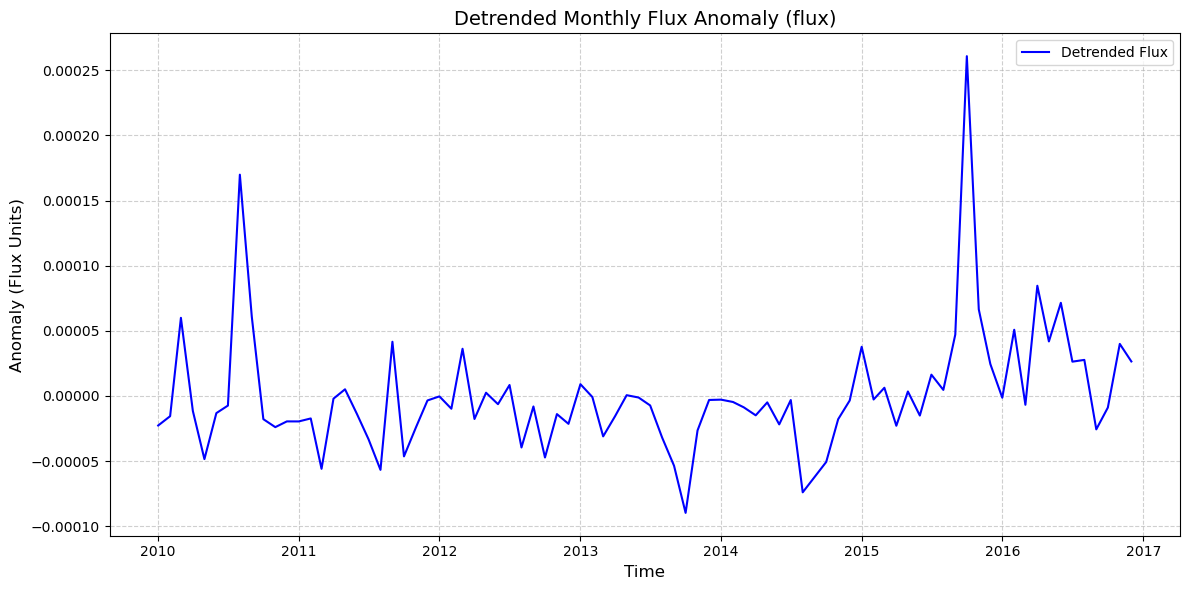

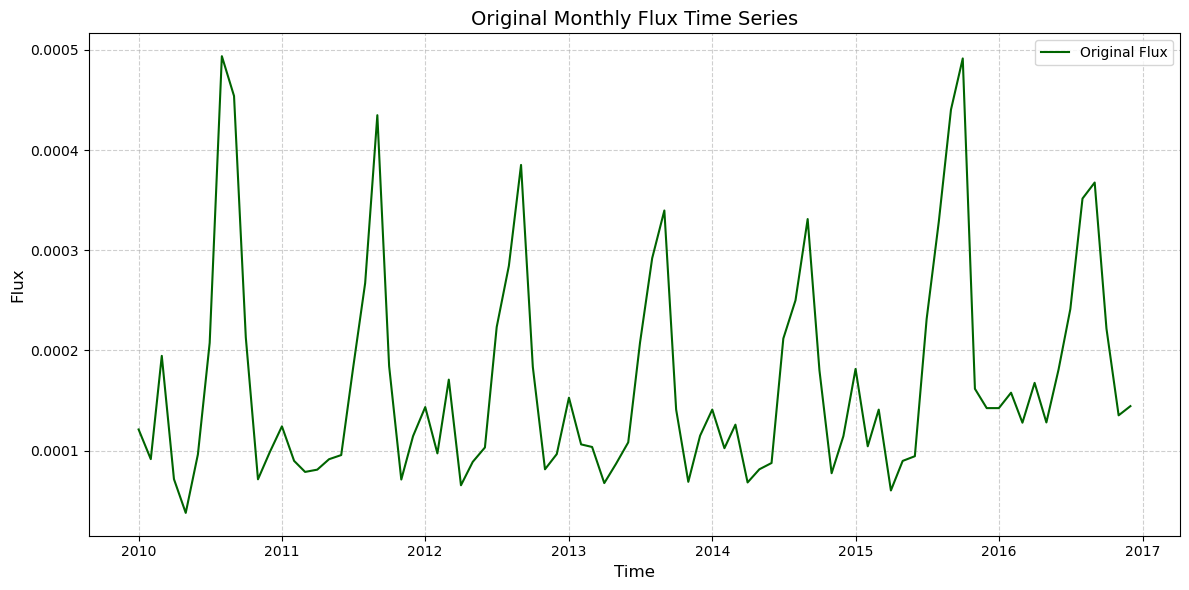

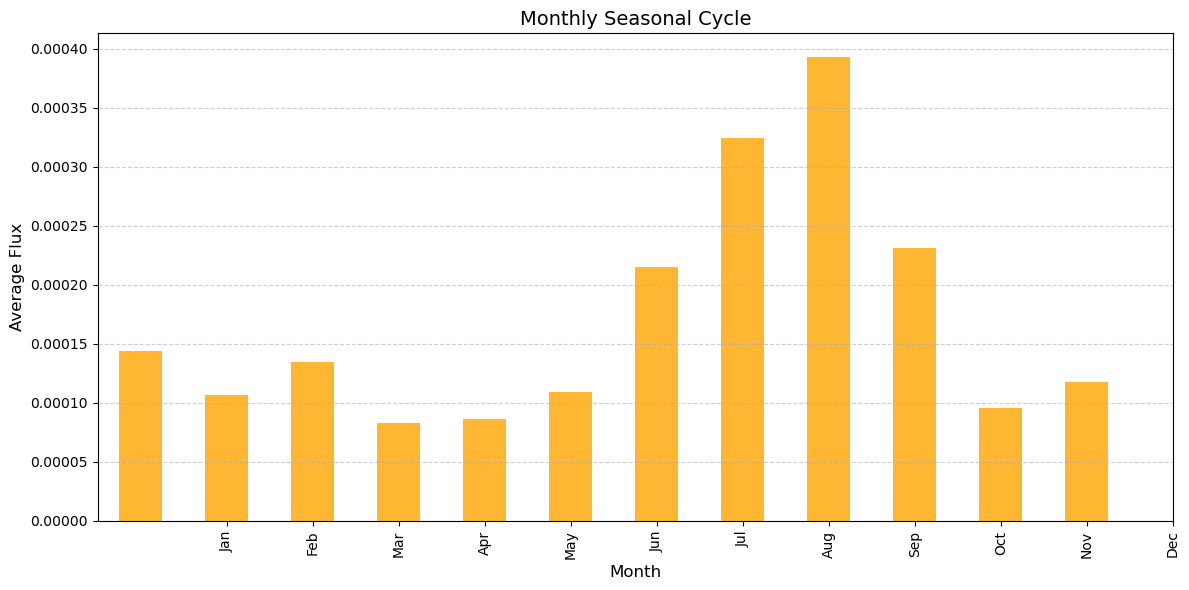

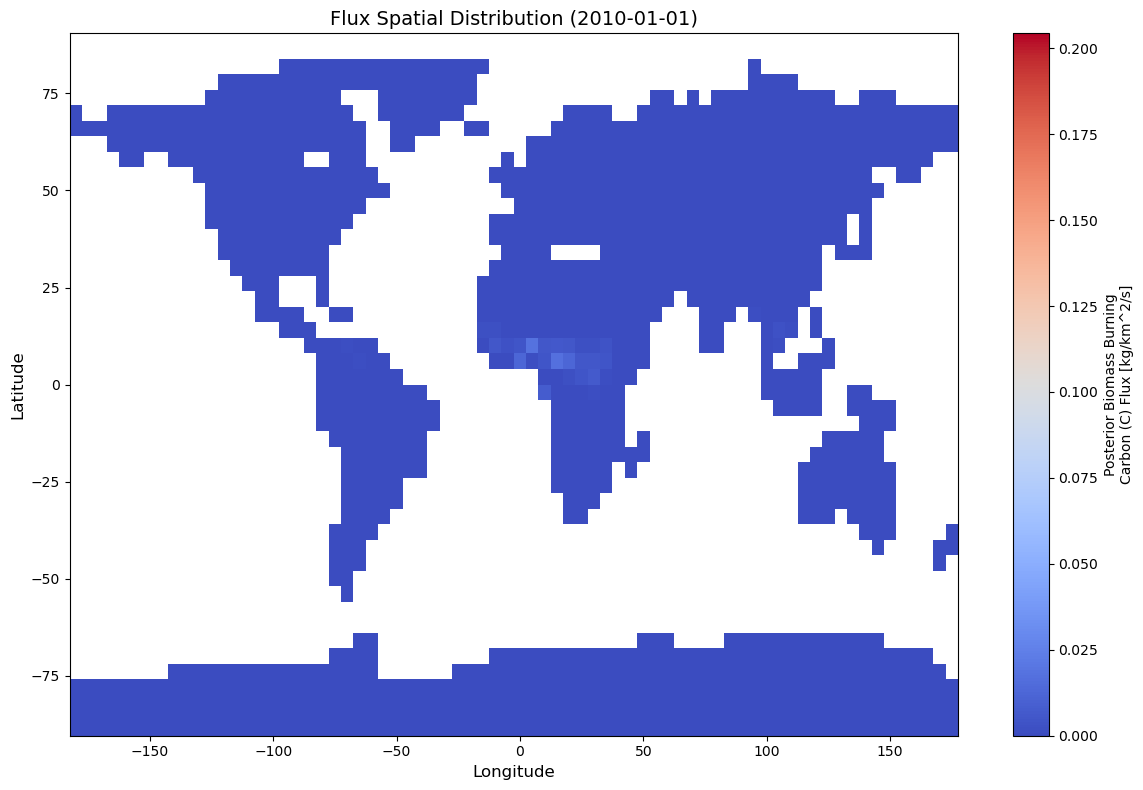

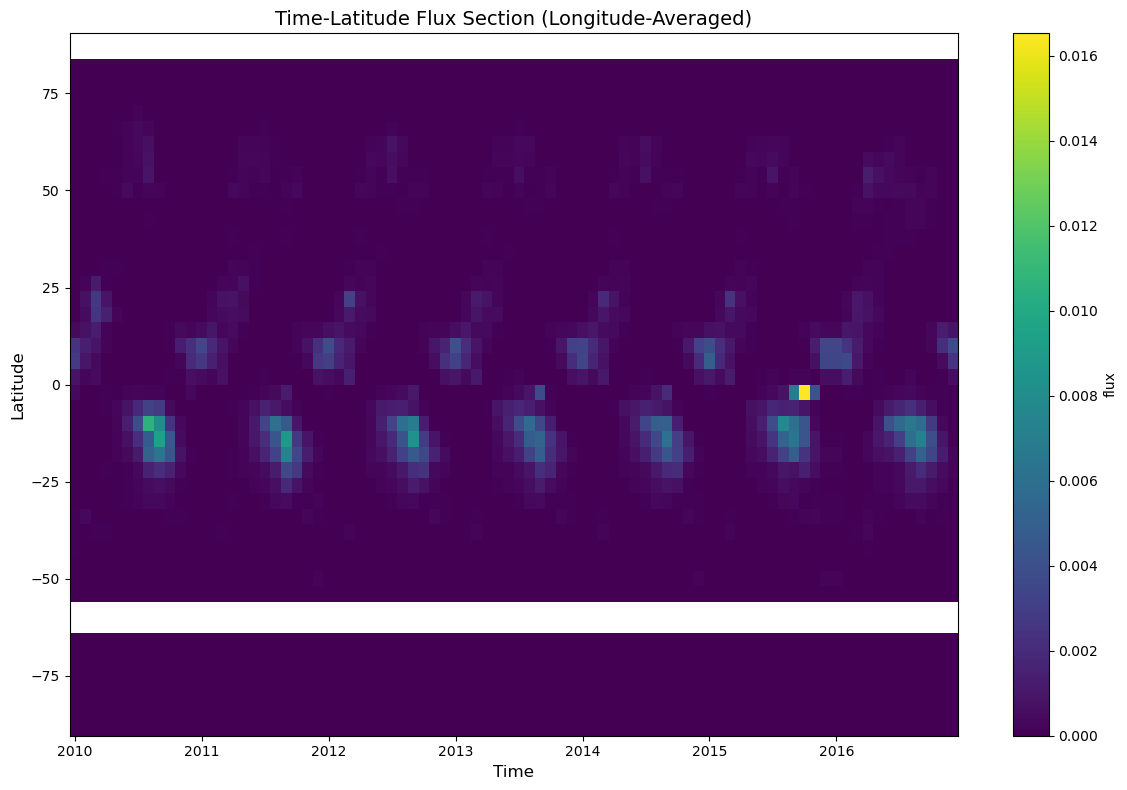

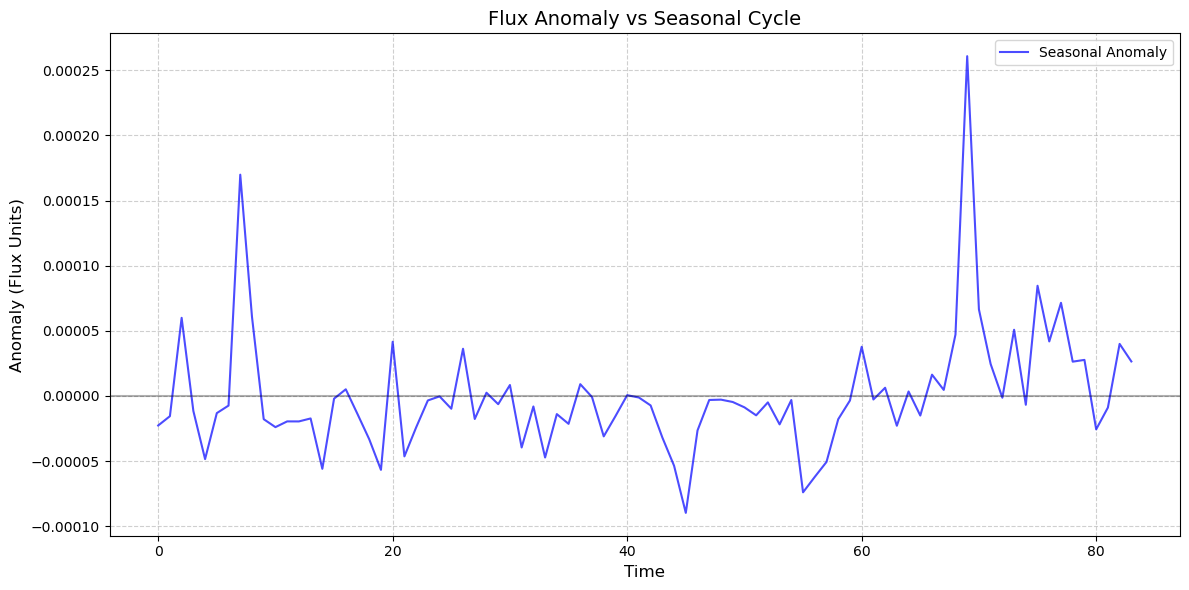

In [147]:
#3. Explore a netCDF dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

# 读取 NetCDF 文件
file_path = r"CMS_Flux_Fire_2010_2016_merged.nc"
ds = xr.open_dataset(file_path)

# ✅ 修正：使用实际存在的变量名 'flux'
variable_name = 'flux'
variable_data = ds[variable_name]

# 确保数据有时间维度
if 'time' not in variable_data.dims:
    raise ValueError(f"Variable '{variable_name}' does not have a time dimension")

# 对空间维度进行平均（lat, lon）
time_series = variable_data.mean(dim=['lat', 'lon'])

# 转换为 pandas Series 以便处理时间
time_series_pd = time_series.to_series()

# 移除月季节性周期
# 1. 按月份分组
monthly_groups = time_series_pd.groupby(time_series_pd.index.month)
# 2. 减去各月的平均值
time_series_detrended = time_series_pd - monthly_groups.transform('mean')

# 转换回 xarray DataArray
time_series_detrended_xr = time_series_detrended.to_xarray()

# ===================================================
# 要求 3.1：绘制去除月季节性周期的时间序列
# ===================================================
plt.figure(figsize=(12, 6))
time_series_detrended_xr.plot(label='Detrended Flux', color='blue', linewidth=1.5)
plt.title(f'Detrended Monthly Flux Anomaly ({variable_name})', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Anomaly (Flux Units)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# ===================================================
# 要求 3.2：制作至少 5 个不同的图表
# ===================================================

# 1. 原始时间序列（未处理）
plt.figure(figsize=(12, 6))
time_series.plot(label='Original Flux', color='darkgreen', linewidth=1.5)
plt.title('Original Monthly Flux Time Series', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Flux', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# 2. 季节性周期（每月平均）
seasonal_cycle = time_series_pd.groupby(time_series_pd.index.month).mean()
plt.figure(figsize=(12, 6))
seasonal_cycle.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Monthly Seasonal Cycle', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Flux', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(range(1, 13), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.tight_layout()
plt.show()

# 3. 空间分布图（2010-01-01 时刻）
plt.figure(figsize=(12, 8))
ds['flux'].isel(time=0).plot.pcolormesh(
    x='lon', y='lat', 
    cmap='coolwarm', 
    add_colorbar=True,
    vmin=ds['flux'].min().values,
    vmax=ds['flux'].max().values
)
plt.title('Flux Spatial Distribution (2010-01-01)', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

# 4. 时间-纬度截面图（经度平均）
time_lat_section = ds['flux'].mean(dim='lon')
plt.figure(figsize=(12, 8))
time_lat_section.plot.pcolormesh(
    x='time', y='lat', 
    cmap='viridis',
    add_colorbar=True
)
plt.title('Time-Latitude Flux Section (Longitude-Averaged)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.tight_layout()
plt.show()

# 5. 通量异常与季节周期对比
plt.figure(figsize=(12, 6))
plt.plot(time_series_detrended_xr, 'b-', alpha=0.7, label='Seasonal Anomaly')

plt.title('Flux Anomaly vs Seasonal Cycle', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Anomaly (Flux Units)', fontsize=12)
plt.axhline(0, color='k', linestyle='-', alpha=0.3)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()